# Introduction

The Palmer Penguins dataset contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica.

These data were collected from 2007 - 2009 by Dr. Kristen Gorman with the Palmer Station Long Term Ecological Research Program, part of the US Long Term Ecological Research Network. The data were imported directly from the Environmental Data Initiative (EDI) Data Portal, and are available for use by CC0 license (“No Rights Reserved”) in accordance with the Palmer Station Data Policy.

I will use this dataset in a classification setting to predict the penguins’ species from anatomical information. For this task, I am planning to train 3 machine learning models, each of which will use a different model architecture. The model architectures I am going to use are a decision tree classifier, a random forest classifier, and a gradient boosting classifier. The reason for training 3 separate models is because I want to compare them with each other in terms of their accuracy and use.

![title](images/lter_penguins.png)

# Setup

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl

def flatten(t):
    return [item for sublist in t for item in sublist]

# Data Loading

In [2]:
# Loading the dataset from the local file.

DATASET_PATH = './data/penguins_size.csv'
dataset = pd.read_csv(DATASET_PATH)

# Data Analysis

## Top 5 rows

The first thing I am going to do is display the head of the dataset, to get a first glimpse at the data.

In [3]:
dataset.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


The dataset contains 7 attributes:
- 6 independent variables / features (island, culmen length, culmen depth, flipper length, body mass, and sex)
- 1 dependent variable / label (species)

By looking at the top 5 rows of the dataset, we can spot a 1 row that has a total of 5 null values.
It is probably a good idea to find out if there are more rows similar to this one and remove them during the data preparation step since such samples provide almost zero value and would most likely create a noise.

## Quick overview

After having a first look at the dataset, I will try to get a more detailed overview of the whole dataset.
I will analyze the rows and their attribute values to get an idea of what operations should be performed during the
data preparation step.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


We can see that 5 out of 7 attributes contain null values.
There are no null values for the target attribute (label) - species - as well as for the island attribute. Other attributes will require some clean-up during the data preparation step. Since the label attribute does not contain any null values (that would make the sample meaningless), there is no actual need to remove any samples from the dataset.

In addition to handling null values, I will also have to transform all the non-numerical features. There are 3 non-numerical features in the dataset - species, island, sex - I will have to analyze them and transform them into numerical features, so they can be handled by our model.

## Analyzing non-numerical attributes

### species

In [5]:
dataset["species"].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

As expected, 'species' is a categorical attribute with 3 possible values. Since this is our target attribute (label), we will have to transform it into the numerical attribute using label encoding, to keep this attribute one-dimensional.  

### island

In [6]:
dataset["island"].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

There are 3 possible values for the 'island' attribute - Biscoe, Dream, Torgersen. Since this attribute is not ordinal, we will use one-hot encoding to transform it into a numerical attribute.

### sex

In [7]:
dataset["sex"].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

There are 3 possible values for the 'sex' attribute, however, it seems like only 2 of those attributes are valid - 'MALE' and 'FEMALE'. The last possible value - '.' - looks incorrectly, so we will treat it as noise and clean it during the data preparation step. Same as with the 'island' attribute, the 'sex' attribute is not ordinal so we will use one-hot encoding to transform it into the numerical attribute.

## Basic statistics

In [8]:
dataset.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


These are the basic statistics for all the numerical features that are present in the dataset. All their values look appropriate, in the way they are spread out across the different percentiles. Standard deviation also does not indicate the presence of any outliers. However, I will try to get a more detailed look into those values by plotting the histogram in the next step.

## Histogram

array([[<AxesSubplot:title={'center':'culmen_length_mm'}>,
        <AxesSubplot:title={'center':'culmen_depth_mm'}>],
       [<AxesSubplot:title={'center':'flipper_length_mm'}>,
        <AxesSubplot:title={'center':'body_mass_g'}>]], dtype=object)

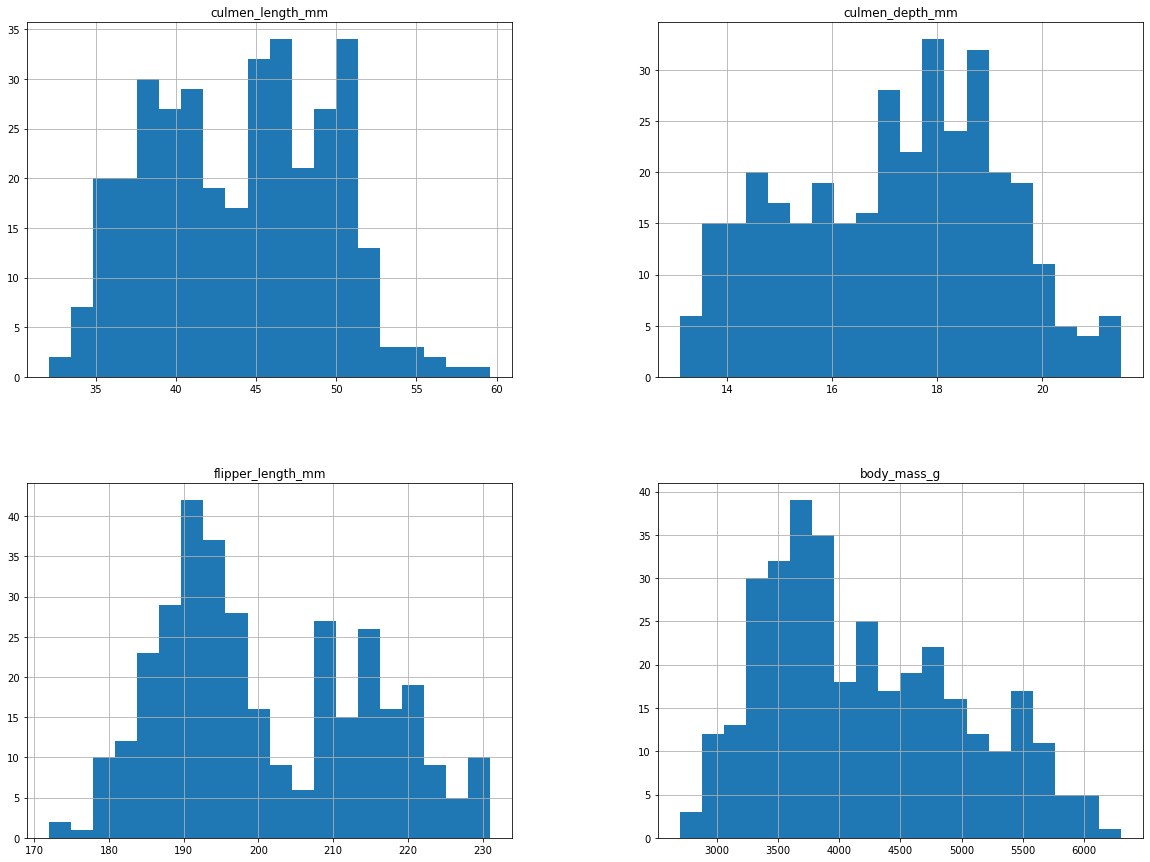

In [9]:
%matplotlib inline
import matplotlib.pyplot as plot
dataset.hist(bins=20, figsize=(20,15))

From looking at the histogram, we can see that there are not any visible outliers in the dataset. One thing we can spot, however, is that for the flipper length attribute, there are plenty of values in the highest bin. This can indicate that the flipper length attribute could have some outliers in the past, but they were capped to the maximum value.

The data distribution of those attributes, based on those histograms is following:
- culmen length and culmen depth distribution is symmetrical
- flipper length distribution is bimodal
- body mass distribution is right-skewed

## Correlations

During this step, we want to see the correlations between the different attributes of the dataset.
By default, the correlation method of the dataset will ignore all the non-numerical attributes.
Since the target attribute is a categorical attribute, we won't be able to see the correlation between the label and all the features.

There are different techniques to measure the correlation between the categorical attributes and other categorical or numerical attributes, however, this is beyond the scope of the project and is not important for this case. Since this dataset already has a small number of features, I am not going to drop any of them, since this would highly reduce the accuracy of the model. Therefore analyzing correlation will be only used for a better understanding of the dataset and the relationships between its attributes.

What would also make sense and could improve the accuracy of the model would be combining some of the categorical attributes with the numerical attributes - for example, gender with body mass. This task, however, also goes beyond the scope of this project so I will skip this step as well.

In [10]:
dataset.corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


There is a high positive correlation between the culmen length and both the flipper length (0.65) and the body mass (0.59), which indicates that penguins with the longer flippers tend to weigh more and also tend to have the longer culmen. There is an even higher positive correlation between the flipper length and the body mass (0.87), which shows a high tendency for penguins with long flippers to weigh more, which makes perfect sense.

Culmen depth, however, has negative correlations with all the other features - culmen length (-0.23), body mass (-0.47), and the flipper length (-0.58). This means that penguins with shallow culmen tend to also have smaller culmen, smaller flippers and they tend to weigh less as well.

# Data Preparation

## Data Cleaning

The first thing that I will have to do during the data preparation step is to clean the data from the null values.
I will first display all the rows that have at least 1 null value for at least 1 of the attributes, to decide on which cleaning method I am going to use. 

Usually, the best approach is to replace the null values with some default values, especially considering the small size of this dataset, but since we could already see a 1 row with almost all the features having null values, it will make more sense to discard this row and all the rows that are similar to it.

In [11]:
dataset[dataset.isna().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


We can see that we have 2 rows in the dataset with almost all features having null values - row 3 and row 339.

In [12]:
dataset = dataset.drop(labels=[3, 339], axis=0)
dataset[dataset.isna().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN


We can see that rows number 3 and 339 have been removed from the dataset. All the other rows have null values only for the 'sex' attribute, so I will replace those null values with the default value using SimpleImputer during the next step.

Before I do this, however, it is important to remember that during the data analysis we found a single row that had an invalid '.' value for the 'sex' attribute. We could handle this row and all the similar rows separately, but it is a probably good idea to set a value of the 'sex' attribute to null for all the rows that have the '.' value, and then let the SimpleImputer handle these rows along with other rows that have the missing values.

In [13]:
dataset.loc[dataset['sex'] == '.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [14]:
dataset["sex"].replace({".": np.NaN}, inplace=True)
dataset.loc[336]

species              Gentoo
island               Biscoe
culmen_length_mm       44.5
culmen_depth_mm        15.7
flipper_length_mm     217.0
body_mass_g          4875.0
sex                     NaN
Name: 336, dtype: object

We can see that the only row that had the '.' value for the 'sex' attribute, got it replaced with the 'NaN' value instead, which will be handled along with other 'NaN' values by a SimpleImputer.

In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
dataset["sex"] = imputer.fit_transform(dataset[["sex"]])

Since the feature that we are imputing values for is a categorical attribute, I used the 'most_frequent' strategy for a SimpleImputer. As the name suggests, this strategy is based on replacing all the missing values with the most frequent value. We can use the 'statistics_' method of a SingleImputer class to see what value was imputed for the 'sex' attribute.

In [16]:
imputer.statistics_

array(['MALE'], dtype=object)

The imputed value for the 'sex' attribute is 'MALE'. This means that all the samples that had a missing value for the 'sex' attribute, should have them replaced by the 'MALE' imputed value. We will verify it, by printing all the rows that previously had a 'NaN' value for the 'sex' attribute (including the row with the '.' value).

In [17]:
dataset.loc[[8,9,10,11,47,246,286,324,336], :]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,MALE
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,MALE
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,MALE
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,MALE
47,Adelie,Dream,37.5,18.9,179.0,2975.0,MALE
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,MALE
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,MALE
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,MALE
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,MALE


Indeed all the 9 rows that had a missing value for the 'sex' attribute got it replaced with the imputed 'MALE' value.

In [18]:
dataset[dataset.isna().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


We can see that all missing values in the dataset have been handled properly, so we can proceed to the next step - Feature Scaling.

## Feature Scaling

Next step of data preparation will be performing the feature scaling on the dataset's attributes. Since I am planning to only use the decision tree based alghoritms there is no actual need for perfoming the feature scaling. The reason why the tree based models do not require scaling is that they are invariant to monotonic transformations of any feature/input/independent variable. However, feature scaling in general is considered as a good habit - it helps with data visualization/manipulation, and it might be useful if at some point I will plan to compare the performance of the tree based model to the model that uses architecture which indeed requires a feature scaling.

For the feature scaling method, I am going to use the Normalization. The reason for picking Normalization over Standarization is that the lack of fixed range that we get using Standarization is a problem for some algorithms (for example Neural Networks). And since we already know that we do not have any outliers in the dataset, there is no need to worry about them affecting the results of the normalization.

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset_numerical = dataset.select_dtypes(include=[np.number])
dataset_numerical_scaled = scaler.fit_transform(dataset_numerical)
dataset_numerical_scaled_frame = pd.DataFrame(dataset_numerical_scaled, index=dataset_numerical.index, columns=list(dataset_numerical))
dataset.update(dataset_numerical_scaled_frame)
dataset

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,0.254545,0.666667,0.152542,0.291667,MALE
1,Adelie,Torgersen,0.269091,0.511905,0.237288,0.305556,FEMALE
2,Adelie,Torgersen,0.298182,0.583333,0.389831,0.152778,FEMALE
4,Adelie,Torgersen,0.167273,0.738095,0.355932,0.208333,FEMALE
5,Adelie,Torgersen,0.261818,0.892857,0.305085,0.263889,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,0.549091,0.071429,0.711864,0.618056,FEMALE
340,Gentoo,Biscoe,0.534545,0.142857,0.728814,0.597222,FEMALE
341,Gentoo,Biscoe,0.665455,0.309524,0.847458,0.847222,MALE
342,Gentoo,Biscoe,0.476364,0.202381,0.677966,0.694444,FEMALE


As a result of Normalization, all the values for all the numerical attributes were scaled to fit in the 0 to 1 range. To keep the categorical attributes unchanged, I filtered them out before passing the dataset to the 'fit_transform' method of the MinMaxScaler class. To make sure that all the numerical values were properly normalized, we can use the 'describe' method of the dataset, that we used before during the data analysis step.

In [20]:
dataset.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,0.429888,0.482282,0.490088,0.417154
std,0.198530,0.235094,0.238334,0.222765
min,0.000000,0.000000,0.000000,0.000000
25%,0.259091,0.297619,0.305085,0.236111
50%,0.449091,0.500000,0.423729,0.375000
75%,0.596364,0.666667,0.694915,0.569444
max,1.000000,1.000000,1.000000,1.000000


We can see that all the numerical values lays between 0 and 1. Another thing that is worth to note is that having normalized numerical values makes it much easier to analyze the data distribution and compare the features to each other. For example, we can see that the feature with the lowest mean value is the 'body_mass' - 0.41. This points to the conclusion that the distribution for the 'body_mass' could be right-skewed. Before normalizing the values, we had to plot the histogram to be able to deduct this information, but right now we can clearly see it by just looking at the numbers.

## Handling non-numerical features

The last step of the data preparation, will be handling the non-numerical features. We have 3 non-numerical - categorical - features in the dataset:
- species - 3 possible values - Adelie, Gento, Chinstrap
- island - 3 possible values - Biscoe, Dream, Torgersen
- sex - 2 possible values - MALE, FEMALE

As I decided during the data analysis, I am going to use label encoder for the 'species' feature and the one-hot encoder for the 'island' and 'sex' features.

In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder = LabelEncoder()
encoded_species = pd.DataFrame(labelencoder.fit_transform(dataset["species"]), index=dataset.index, columns=["species"])

onehotencoder = OneHotEncoder(sparse=False)
encoded_island = pd.DataFrame(onehotencoder.fit_transform(dataset[["island"]]), index=dataset.index, columns=flatten(map(lambda x: "island_" + x, onehotencoder.categories_)))

onehotencoder = OneHotEncoder(sparse=False)
encoded_sex = pd.DataFrame(onehotencoder.fit_transform(dataset[["sex"]]), index=dataset.index, columns=flatten(map(lambda x: "sex_" + x, onehotencoder.categories_)))

Once have all the categorical features encoded into the numerical features, we can get an overview of them by combining them using the 'concat' function from the pandas library.

In [22]:
encoded_combined = pd.concat([encoded_species, encoded_island, encoded_sex], axis=1)
encoded_combined

,species,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,0,0.0,0.0,1.0,0.0,1.0
1,0,0.0,0.0,1.0,1.0,0.0
2,0,0.0,0.0,1.0,1.0,0.0
4,0,0.0,0.0,1.0,1.0,0.0
5,0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...
338,2,1.0,0.0,0.0,1.0,0.0
340,2,1.0,0.0,0.0,1.0,0.0
341,2,1.0,0.0,0.0,0.0,1.0
342,2,1.0,0.0,0.0,1.0,0.0


We can see that as a result of encoding 3 categorical features, we got 6 columns:
- 1 column for the 'species' feature - label encoded
- 3 columns for the 'island' feature - one-hot encoded
- 2 columns for the 'sex' feature - one-hot encoded

One more information that is crucial to know is the mapping of the encoded 'species' values to the different penguin species. We can get this information by using the 'classes_' property of the LabelEncoder object which we used for encoding the 'species' categorical attribute.

In [23]:
labelencoder.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

Since the encoded values of the 'species' attribute represent the index number from this array, the mapping is following:
- value '0' represents Adelie species
- value '1' represents Chinstrap species
- value '2' represents Gentoo species

The last step will be to remove the categorical features from the original dataset and then add the encoded features in their place.

In [24]:
dataset.drop(["island", "sex", "species"], axis=1, inplace=True)
dataset = pd.concat([dataset, encoded_island, encoded_sex, encoded_species], axis=1)
dataset

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE,species
0,0.254545,0.666667,0.152542,0.291667,0.0,0.0,1.0,0.0,1.0,0
1,0.269091,0.511905,0.237288,0.305556,0.0,0.0,1.0,1.0,0.0,0
2,0.298182,0.583333,0.389831,0.152778,0.0,0.0,1.0,1.0,0.0,0
4,0.167273,0.738095,0.355932,0.208333,0.0,0.0,1.0,1.0,0.0,0
5,0.261818,0.892857,0.305085,0.263889,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
338,0.549091,0.071429,0.711864,0.618056,1.0,0.0,0.0,1.0,0.0,2
340,0.534545,0.142857,0.728814,0.597222,1.0,0.0,0.0,1.0,0.0,2
341,0.665455,0.309524,0.847458,0.847222,1.0,0.0,0.0,0.0,1.0,2
342,0.476364,0.202381,0.677966,0.694444,1.0,0.0,0.0,1.0,0.0,2


At this point we have the dataset where:
- All the missing values were removed from the dataset
- All the categorical attributes were encoded into numerical attributes
- All the numerical features were normalized

As a result, we have a dataset with no missing values, only numerical features in the range from 0 to 1 and the numerical label with the possible values of 0 (Adelie), 1 (Chinstrap), or 2 (Gentoo). 

# Splitting dataset

The last thing that I will do before training the models is splitting the dataset into the input data - predictors matrix - and the output data - labels vector. After that, I will perform one more split on both the predictors and the test labels. 

In [25]:
X = dataset.drop(columns=["species"])
X

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,0.254545,0.666667,0.152542,0.291667,0.0,0.0,1.0,0.0,1.0
1,0.269091,0.511905,0.237288,0.305556,0.0,0.0,1.0,1.0,0.0
2,0.298182,0.583333,0.389831,0.152778,0.0,0.0,1.0,1.0,0.0
4,0.167273,0.738095,0.355932,0.208333,0.0,0.0,1.0,1.0,0.0
5,0.261818,0.892857,0.305085,0.263889,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
338,0.549091,0.071429,0.711864,0.618056,1.0,0.0,0.0,1.0,0.0
340,0.534545,0.142857,0.728814,0.597222,1.0,0.0,0.0,1.0,0.0
341,0.665455,0.309524,0.847458,0.847222,1.0,0.0,0.0,0.0,1.0
342,0.476364,0.202381,0.677966,0.694444,1.0,0.0,0.0,1.0,0.0


This transformed dataset will be the input data for the machine learning model. The model will use the input data for the training process along with the output data, to which it will compare its predictions. The input data contains all the features - predictors - of the dataset, while the label column was removed from it.

In [26]:
y = dataset["species"].copy()
y

0      0
1      0
2      0
4      0
5      0
      ..
338    2
340    2
341    2
342    2
343    2
Name: species, Length: 342, dtype: int64

This vector of the labels will be the output data for the machine learning model. As mentioned before the output data will be used by the model for comparing its predictions during the training process. The output data contains only the label column that was transformed into the vector of data values, while all the features columns were removed from it.

For splitting the dataset into the training set and the test set, I am going follow the rule of thumb of using the 80% of the data for training and the 20% of the data for testing. I am also going to set the 'random_state' parameter of a 'train_test_split' method to a fixed value, so we will always get the same split.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

At this point we have the dataset that is prepared and ready for training.

# Training

In this step, I am going to train 3 different machine learning models, each of them using a different model architecture.

I am going to use the RandomizedSearchCV class to fine-tune the hyperparameters of each model. The reason for selecting RandomizedSearchCV class over GridSearchCV class is mostly the performance - even with such a small dataset, it would still take some time to check all the possible permutations for the given hyperparameter values, if the range of values is high.

Same as in this example - and especially with the larger datasets - randomized search would be a preferred choice. Another interesting approach would be to combine randomized search with a grid search - use the random search with a large hyperparameter grid and then use the results of the random search to build a focused hyperparameter grid around the best performing hyperparameter values. For this case, however, I am going to simply use a random search.

Since all of the model architecture classes as well as a RandomizedSearchCV use some kind of randomness inside, all of them take the 'random_state' parameter in the constructor. I am going to always set it to a fixed value in order to get predictable results.

## Decision Tree

The first machine learning model that I am going to train, will be using Decision Tree model architecture. I decided to start with Decision Tree because it's the simplest model architecture from those 3 that I selected for this project and the other 2 model architectures - Random Forest & Gradient Boosting - are based on it.

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt_model = DecisionTreeClassifier(random_state=42)
dt_hyperparams_values = {
    "max_depth": list(range(5, 15)),
    "max_leaf_nodes": list(range(5, 15)),
    "min_samples_leaf": list(range(2, 10)),
    "min_samples_split": list(range(5, 15)),
    "criterion": ["gini", "entropy"]
}
dt_randomizedsearch = RandomizedSearchCV(dt_model, dt_hyperparams_values, cv=5, random_state=42, n_iter=100)
dt_randomizedsearch.fit(X_train, y_train)
dt_model = dt_randomizedsearch.best_estimator_
dt_model

DecisionTreeClassifier(criterion='entropy', max_depth=14, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

I was experimenting with the hyperparameter tuning multiple times, each time with different value ranges - starting from the wide range of values for each hyperparameter and then narrowing it down around the value that was selected for the 'best_estimator_'. The final hyperparameter values for the DecisionTreeClassifier are:
- criterion: entropy
- max_depth: 14
- max_leaf_nodes: 14
- min_samples_leaf: 2
- min_samples_split: 5

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(random_state=42)
rf_hyperparams_values = {
    "n_estimators": list(range(150, 200)),
    "bootstrap": [True, False],
    "max_depth": list(range(30, 50)),
    "max_leaf_nodes": list(range(10, 20)),
    "min_samples_leaf": list(range(2, 10)),
    "min_samples_split": list(range(10, 20)),
    "criterion": ["gini", "entropy"]
}
rf_randomizedsearch = RandomizedSearchCV(rf_model, rf_hyperparams_values, cv=5, random_state=42, n_iter=10)
rf_randomizedsearch.fit(X_train, y_train)
rf_model = rf_randomizedsearch.best_estimator_
rf_model

RandomForestClassifier(bootstrap=False, max_depth=45, max_leaf_nodes=17,
                       min_samples_leaf=4, min_samples_split=11,
                       n_estimators=184, random_state=42)

I was experimenting with the hyperparameter tuning multiple times, each time with different value ranges - starting from the wide range of values for each hyperparameter and then narrowing it down around the value that was selected for the 'best_estimator_'. The final hyperparameter values for the RandomForestClassifier are:
- bootstrap: False
- max_depth: 45
- max_leaf_nodes: 17
- min_samples_leaf: 4
- min_samples_split: 11
- n_estimators: 184

## Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

gb_model = GradientBoostingClassifier(random_state=42)
gb_hyperparams_values = {
    "learning_rate": [0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.350],
    "n_estimators": list(range(120, 170)),
    "max_depth": list(range(50, 70)),
    "max_leaf_nodes": list(range(5, 15)),
    "min_samples_leaf": list(range(5, 15)),
    "min_samples_split": list(range(15, 25)),
    "criterion": ["friedman_mse", "squared_error"]
}
gb_randomizedsearch = RandomizedSearchCV(gb_model, gb_hyperparams_values, cv=5, random_state=42, n_iter=10)
gb_randomizedsearch.fit(X_train, y_train)
gb_model = gb_randomizedsearch.best_estimator_
gb_model

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.325,
                           max_depth=51, max_leaf_nodes=13, min_samples_leaf=13,
                           min_samples_split=24, n_estimators=148,
                           random_state=42)

I was experimenting with the hyperparameter tuning multiple times, each time with different value ranges - starting from the wide range of values for each hyperparameter and then narrowing it down around the value that was selected for the 'best_estimator_'. The final hyperparameter values for the GradientBoostingClassifier are:
- criterion: squared_error
- learning_rate: 0.325
- max_depth: 51
- max_leaf_nodes: 13
- min_samples_leaf: 13
- min_samples_split: 24
- n_estimators: 148

# Evaluation

## Decision Tree

In [31]:
from sklearn.metrics import accuracy_score
dt_model.fit(X_train, y_train)
dt_model_predictions = dt_model.predict(X_test)
accuracy_score(dt_model_predictions, y_test)

0.9710144927536232

## Random Forest

In [32]:
from sklearn.metrics import accuracy_score
rf_model.fit(X_train, y_train)
rf_model_predictions = rf_model.predict(X_test)
accuracy_score(rf_model_predictions, y_test)

0.9855072463768116

## Gradient Boosting

In [33]:
from sklearn.metrics import accuracy_score
gb_model.fit(X_train, y_train)
gb_model_predictions = gb_model.predict(X_test)
accuracy_score(gb_model_predictions, y_test)

0.9855072463768116

# Prediction

## Decision Tree

## Random Forest

## Gradient Boosting